# Hamiltonian Monte Carlo<br><sub>Not quite NUTS but just unhinged enough to give you the right ideas</sub><!-- https://www.johndcook.com/t_normal_mixture.pdf -->

<!--
$\begin{align}
\frac{1}{\sqrt{2\pi}} \frac {\frac{\nu}{2}^{\frac{\nu}{2}}}{\Gamma \left(\frac{\nu}{2}\right)}  \int  e^{-\frac{1}{2}\tau_i(y_i^2 + \nu) } \tau_i^{\frac{\nu+1}{2}-1} d\tau_i &={} \frac{1}{\sqrt{2\pi}} \frac{\sqrt{\frac{\nu}{2}}}{\sqrt{\frac{\nu}{2}}} \frac {\frac{\nu}{2}^{\frac{\nu}{2}}}{\Gamma \left(\frac{\nu}{2}\right)} \Gamma \left(\frac{\nu+1}{2}\right) \left(\frac{y_i^2 + \nu}{2}\right)^{-\frac{\nu+1}{2}} \\
&={} \frac{1}{\sqrt{\pi\nu}}  \frac {\frac{\nu}{2}^{\frac{\nu+1}{2}}}{\Gamma \left(\frac{\nu}{2}\right)} \Gamma \left(\frac{\nu+1}{2}\right) \left(\frac{y_i^2 + \nu}{2}\right)^{-\frac{\nu+1}{2}}\\
&={} \frac{1}{\sqrt{\pi\nu}}  \frac{\Gamma \left(\frac{\nu+1}{2}\right)}{\Gamma \left(\frac{\nu}{2}\right)} \frac{\nu}{2}^{\frac{\nu+1}{2}} \left(\frac{y_i^2 + \nu}{2}\right)^{-\frac{\nu+1}{2}}\\
&={} \frac{1}{\sqrt{\pi\nu}}  \frac{\Gamma \left(\frac{\nu+1}{2}\right)}{\Gamma \left(\frac{\nu}{2}\right)} \left(\frac{y_i^2}{\nu} + 1\right)^{-\frac{\nu+1}{2}}
\end{align}$
-->

In [1]:
import pymc
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import arviz as az
import logging
import pandas as pd
from matplotlib import cm

## Week 6 Homework

---

# Q1: Let's start having some *real* fun...

We previously considered the normal-gamma specification 

$$\scriptsize
\begin{align*}
p(\theta,\tau|x) &\propto{} p(\theta,\tau,x) = p(x|\theta)p(\theta)p(\tau) \quad (\theta \perp\!\!\perp \tau) \leftarrow \text{independent priors} & p(\theta|x,\theta_0,\tau_0, \tau) &={} \text{N}\left(\frac{\left(\tau_0 \theta_0+\tau\sum_{i=1}^{n}x_{i}\right)}{(\tau_0+n\tau)}, \sigma^{-2}=\tau_0+n\tau \right)\\
&={}  \left[\prod_{i=1}^n\sqrt{\frac{\tau}{2\pi}} e^{-\frac{\tau\left(x_i-\theta\right)^2}{2}}\right] \sqrt{\frac{\tau_0}{2\pi}} e^{-\frac{\tau_0\left(\theta-\theta_0\right)^2}{2}} \frac{\beta ^{\alpha}}{\Gamma(\alpha)} \tau^{\alpha -1}e^{-\beta \tau} & p(\tau|x, \alpha, \beta, \theta) &={} \text{Gamma}\left(\frac{\alpha}{2}+\frac{n}{2}, \frac{\beta}{2}+\frac{1}{2}\sum_{i=1}^n\left(x_i-\theta\right)^2 \right)\\{}\\
\end{align*}$$

How about instead we consider a "[location-scale-t](https://en.wikipedia.org/wiki/Student%27s_t-distribution#Location-scale_t-distribution)-norm-halfnorm-discrete-uniform" specification?

$$\large
\overset{x_i\; \sim\; \text{location-scale-t}(\mu, \sigma^2, \nu)}{\quad\quad\quad p(x|\mu,\sigma^2, \nu)} = {\prod_{i=1}^n
\frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right) \sqrt{\pi \nu \sigma^2}}\left(1+\frac{1}{\nu} \frac{(x_i-\mu)^2}{\sigma^2}\right)^{-(\nu+1) / 2}}$$

$$\scriptsize 
\begin{align}
p(\mu | \mu_0, \tau_0) &={} \sqrt{\frac{\tau_0}{2\pi}} e^{-\frac{\tau_0}{2}\left(\mu-\mu_0\right)^2} & p(\sigma^2 | \sigma_0^2) &={} \sqrt{\frac{2}{\pi\sigma_0^2}} \exp \left(-\frac{(\sigma^2)^2}{2 \sigma_0^2}\right) 1_{[0,\infty]}(\sigma^2) & p(\nu=i) &={} \Bigg\{ \begin{array}{cl} \frac{1}{100} & \text{for }i=1,\cdots,100\\ 0 & \text{otherwise} \end{array}\\
& \textrm{normal} && \textrm{half-normal} && \textrm{discrete uniform}
\end{align}
$$

Um yeah we're gonna need a Metroposlis cleanup on aisles one two and three  
(or a slice or adapative squeeze rejection sampling steps... in place of Metroposlis steps)

*Implement the a Metroposlis within Gibbs algorithm to smaple from the posterior of the above specification. Use a "smallish" sample size, say $n=100$ and implement your acceptance probability on a log-scale as described in [piazza post @65_f1](https://piazza.com/class/m5jvyco84083fm/post/65_f1)*



In [2]:
def likelihood(x, mu, sigma2, nu):
    n = len(x)
    gamma_term = (np.math.gamma((nu + 1) / 2) / (np.math.gamma(nu / 2) * np.sqrt(np.pi * nu * sigma2)))
    
    # Location-scale t-distribution likelihood
    return np.sum(np.log(gamma_term * (1 + (x - mu)**2 / (nu * sigma2))**(-(nu + 1) / 2)))

def prior_mu(mu, mu0, tau0):
    return -0.5 * np.log(2 * np.pi * tau0**2) - (mu - mu0)**2 / (2 * tau0**2)

def prior_sigma2(sigma2, sigma0):
    if sigma2 > 0:
        return -0.5 * np.log(2 * np.pi * sigma0**2) - sigma2 / (2 * sigma0**2)
    else:
        return 0

def prior_nu(nu):
    if 1 <= nu <= 100:
        return np.log(1 / 100)  # Uniform prior on nu
    else:
        return 0  

In [21]:
def mh_gibbs0501(x, mu0, tau0, sigma0, nu_current, n):
    
    G = 1000  

    mu = np.zeros(G)  
    sigma2 = np.zeros(G) 
    nu = np.zeros(G) 

    mu[0] = 0 
    sigma2[0] = 1  
    nu[0] = 5 

    for g in range(1, G):  

        # MU
        
        # propose
        mu_tilde = np.random.normal(mu[g-1], tau0)

        # log likelihood
        log_likelihood_mu_tilde = likelihood(x, mu_tilde, sigma2[g-1], nu[g-1])
        log_likelihood_mu = likelihood(x, mu[g-1], sigma2[g-1], nu[g-1])
        # prior for proposed and current
        log_prior_mu_tilde = prior_mu(mu_tilde, mu0, tau0)
        log_prior_mu = prior_mu(mu[g-1], mu0, tau0)
        # accept/reject
        log_mh_mu_calc = (log_likelihood_mu_tilde + log_prior_mu_tilde) - (log_likelihood_mu + log_prior_mu)
        acceptance_probability_mu = min(1, np.exp(log_mh_mu_calc))

        if stats.uniform().rvs() < acceptance_probability_mu:
            mu[g] = mu_tilde
        else:
            mu[g] = mu[g-1]
        
        # SIGMA2
        
        sigma2_tilde = np.random.normal(sigma2[g-1], 0.1)

        log_likelihood_sigma2_tilde = likelihood(x, mu[g], sigma2_tilde, nu[g-1])
        log_likelihood_sigma2 = likelihood(x, mu[g], sigma2[g-1], nu[g-1])

        log_prior_sigma2_tilde = prior_sigma2(sigma2_tilde, sigma0)
        log_prior_sigma2 = prior_sigma2(sigma2[g-1], sigma0)

        log_mh_sigma2_calc = (log_likelihood_sigma2_tilde + log_prior_sigma2_tilde) - (log_likelihood_sigma2 + log_prior_sigma2)
        acceptance_probability_sigma2 = min(1, np.exp(log_mh_sigma2_calc))

        if stats.uniform().rvs() < acceptance_probability_sigma2:
            sigma2[g] = sigma2_tilde
        else:
            sigma2[g] = sigma2[g-1]
        
        # NU
        
        nu_tilde = np.random.randint(1, 101)

        log_likelihood_nu_tilde = likelihood(x, mu[g], sigma2[g], nu_tilde)
        log_likelihood_nu = likelihood(x, mu[g], sigma2[g], nu[g-1])

        log_prior_nu_tilde = prior_nu(nu_tilde)
        log_prior_nu = prior_nu(nu[g-1])

        log_mh_nu_calc = (log_likelihood_nu_tilde + log_prior_nu_tilde) - (log_likelihood_nu + log_prior_nu)
        acceptance_probability_nu = min(1, np.exp(log_mh_nu_calc))

        if stats.uniform().rvs() < acceptance_probability_nu:
            nu[g] = nu_tilde
        else:
            nu[g] = nu[g-1]

    return mu, sigma2, nu


In [22]:
mu0 = 0
tau0 = 1
sigma0 = 1
nu_current = 30
n = 100  
mu_true = 0
sigma2_true = 1
nu_true = 5
x = stats.t(df=nu_true, loc=mu_true, scale=np.sqrt(sigma2_true)).rvs(n)  

mu, sigma2, nu = mh_gibbs0501(x, mu0, tau0, sigma0, nu_current, n)

burn_in = 100

mu_burned = mu[burn_in:]
sigma2_burned = sigma2[burn_in:]
nu_burned = nu[burn_in:]

In [23]:
# 95% confidence interval and mean 
mu_mean = np.mean(mu_burned)
sigma2_mean = np.mean(sigma2_burned)
nu_mean = np.mean(nu_burned)

mu_ci = np.percentile(mu_burned, [2.5, 97.5])
sigma2_ci = np.percentile(sigma2_burned, [2.5, 97.5])
nu_ci = np.percentile(nu_burned, [2.5, 97.5])

print(f"mu mean: {mu_mean}")
print(f"sigma^2 mean: {sigma2_mean}")
print(f"nu mean: {nu_mean}")

print(f"mu 95% CI: {mu_95_ci}")
print(f"sigma^2 95% CI: {sigma2_95_ci}")
print(f"nu 95% CI: {nu_95_ci}")


mu mean: -0.02516406501238167
sigma^2 mean: 1.165646579754027
nu mean: 24.238888888888887
mu 95% CI: [-0.32451143  0.11467371]
sigma^2 95% CI: [0.66298699 1.85628167]
nu 95% CI: [ 3. 90.]


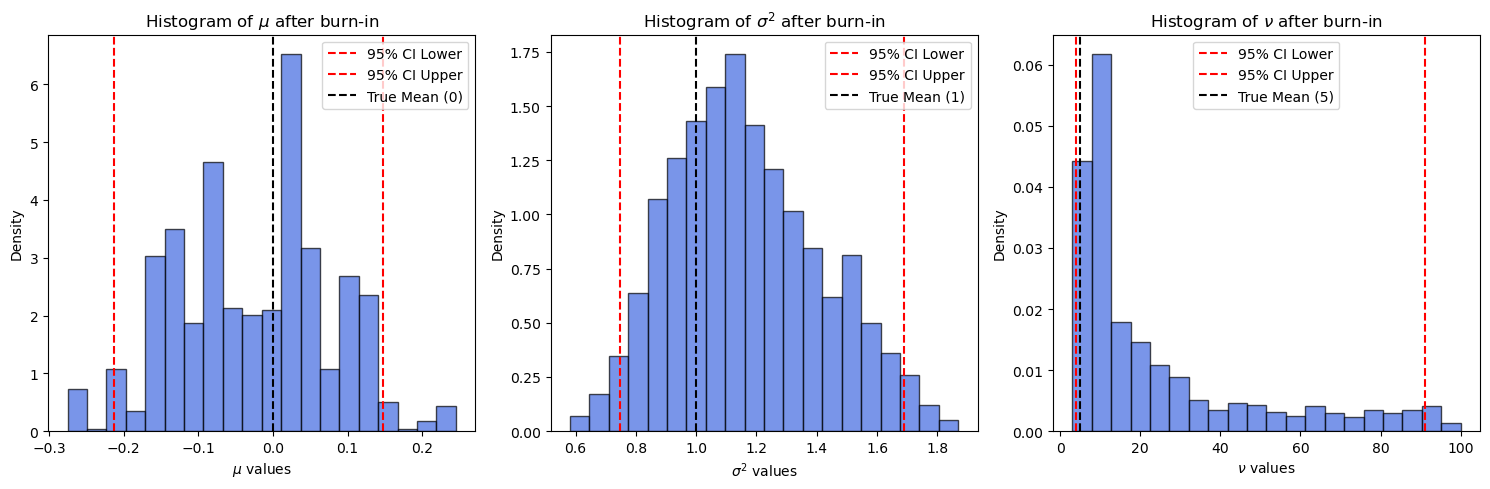

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plot for mu
ax[0].hist(mu_burned, bins=20, alpha=0.7, color='royalblue', edgecolor='black', density=True)
ax[0].axvline(mu_ci[0], color='red', linestyle='dashed', label="95% CI Lower")
ax[0].axvline(mu_ci[1], color='red', linestyle='dashed', label="95% CI Upper")
ax[0].axvline(mu_true, color='black', linestyle='dashed', label="True Mean (0)")
ax[0].set_title(r"Histogram of $\mu$ after burn-in")
ax[0].set_xlabel(r"$\mu$ values")
ax[0].set_ylabel("Density")
ax[0].legend()

# Plot for sigma2
ax[1].hist(sigma2_burned, bins=20, alpha=0.7, color='royalblue', edgecolor='black', density=True)
ax[1].axvline(sigma2_ci[0], color='red', linestyle='dashed', label="95% CI Lower")
ax[1].axvline(sigma2_ci[1], color='red', linestyle='dashed', label="95% CI Upper")
ax[1].axvline(sigma2_true, color='black', linestyle='dashed', label="True Mean (1)")
ax[1].set_title(r"Histogram of $\sigma^2$ after burn-in")
ax[1].set_xlabel(r"$\sigma^2$ values")
ax[1].set_ylabel("Density")
ax[1].legend()

# Plot for nu
ax[2].hist(nu_burned, bins=20, alpha=0.7, color='royalblue', edgecolor='black', density=True)
ax[2].axvline(nu_ci[0], color='red', linestyle='dashed', label="95% CI Lower")
ax[2].axvline(nu_ci[1], color='red', linestyle='dashed', label="95% CI Upper")
ax[2].axvline(nu_true, color='black', linestyle='dashed', label="True Mean (5)")
ax[2].set_title(r"Histogram of $\nu$ after burn-in")
ax[2].set_xlabel(r"$\nu$ values")
ax[2].set_ylabel("Density")
ax[2].legend()

plt.tight_layout()
plt.show()

# Q2: explore the role of sample size in providing inference for the degrees of freedom parameter $\nu$

*Implement the specification above using `PyMC` where you can explore inference on $\nu$ at different sample sizes. Provide a summarization and explanation of your findings.*

In [41]:
mu_true = 0
sigma2_true = 1
nu_true = 5
sample_sizes = [10, 50, 100, 500]

traces = {}
for n in sample_sizes:
    x = stats.t(df=nu_true, loc=mu_true, scale=np.sqrt(sigma2_true)).rvs(n)

    with pymc.Model() as model:
        # Priors
        mu = pymc.Normal('mu', mu=0, sigma=1)
        sigma2 = pymc.HalfNormal('sigma2', sigma=1)
        nu = pymc.DiscreteUniform('nu', lower=1, upper=100)

        # Likelihood (location-scale t-distribution)
        likelihood = pymc.StudentT('x', nu=nu, mu=mu, sigma=sigma2, observed=x)

        # Sampling using MCMC
        trace = pymc.sample(2000, tune=1000)

    traces[n] = trace

    # summary statistics for nu
    print(az.summary(trace, var_names=["nu"], hdi_prob=0.95))

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma2]
>Metropolis: [nu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


     mean      sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
nu  54.06  27.473       9.0      100.0      0.674    0.479    1676.0   

    ess_tail  r_hat  
nu    1918.0    1.0  


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma2]
>Metropolis: [nu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


      mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
nu  45.714  28.95       3.0       94.0      0.837    0.592    1090.0   

    ess_tail  r_hat  
nu    1133.0   1.01  


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma2]
>Metropolis: [nu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


      mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
nu  17.329  19.75       2.0       66.0      1.228    0.869     228.0   

    ess_tail  r_hat  
nu     446.0   1.01  


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma2]
>Metropolis: [nu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


     mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
nu  7.244  6.401       4.0       12.0      0.577    0.409     323.0     249.0   

    r_hat  
nu   1.02  


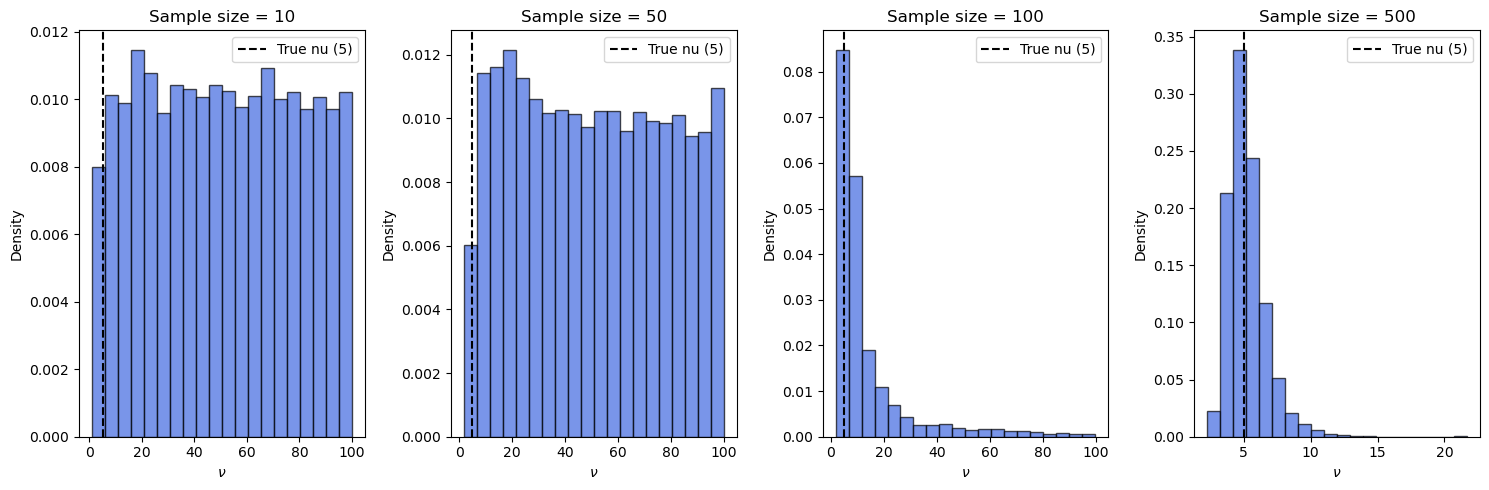

In [23]:
fig, ax = plt.subplots(1, len(sample_sizes), figsize=(15, 5))

for i, n in enumerate(sample_sizes):
    ax[i].hist(results[n], bins=20, alpha=0.7, color='royalblue', edgecolor='black', density=True)
    ax[i].axvline(nu_true, color='black', linestyle='dashed', label=f"True nu ({nu_true})")
    ax[i].set_title(f"Sample size = {n}")
    ax[i].set_xlabel(r"$\nu$")
    ax[i].set_ylabel("Density")
    ax[i].legend()

plt.tight_layout()
plt.show()

#### Provide a summarization and explanation of your findings.

mu_true = 0
sigma2_true = 1
nu_true = 5
sample_sizes = [10, 50, 100, 500]

Mean 
* we can see that the mean if nu is closer to nu_true=5 when sample sizes are larger
* we see this in the histograms where in sample_size=500, the histogram is peaking near 5
* where sample sizes are larger, the mean is close to 50 which is half way from 0-100

Standard Deviation and Spread
* the sd is lower (less variance) when sample sizes are larger, while the sd is higher when sample sizes are smaller
* from the histogram, we see that it peaks near 5 when sample sizes are large, and looks uniform when size is smaller

HDI
* the interval from hdi_2.5% to hdi_97.5% is smaller when sample sizes are larger

We can see that larger sample sizes are good for nu to converge to nu_true=5. this is because when sample size increases, the precision is better and the posterior is more concentrated on the true value. 


# Q3: the posterior predictive distribution does something like the following...

Let $p(\tau_i)$ be $\require{cancel} \textrm{gamma}\big(\tau_i | \alpha = \frac{\nu}{2}, \overset{\textrm{rate}\xcancel{\textrm{scale}}}{\beta = \frac{\nu}{2}}\big)$ and let $p(y_i|\tau_i)$ be $\textrm{N}(y_i | 0,\tau_i)$ and now integrate out the uncertainty in $\tau_i$ and see what distribution is left over for $y_i$.

*Go look at the gamma distribution and remember that you know that the integrals of unnormalized densities are the inverse of their normalizing constants. Then go look at the t distribution and determine what distribution the following expression defines. Then explain why the behavior demonstrated here is analagous to that of the posterior predictive distribution.*

$$\int p(y_i|\tau_i) p(\tau_i)  d\tau_i = \int \sqrt{\frac{\tau_i}{2\pi}}e^{-\frac{1}{2}\tau_i y_i^2} \frac {\frac{\nu}{2}^{\frac{\nu}{2}}}{\Gamma \left(\frac{\nu}{2}\right)} \tau_i^{\frac{\nu}{2}-1}e^{-\frac{\nu}{2}\tau_i} d\tau_i$$



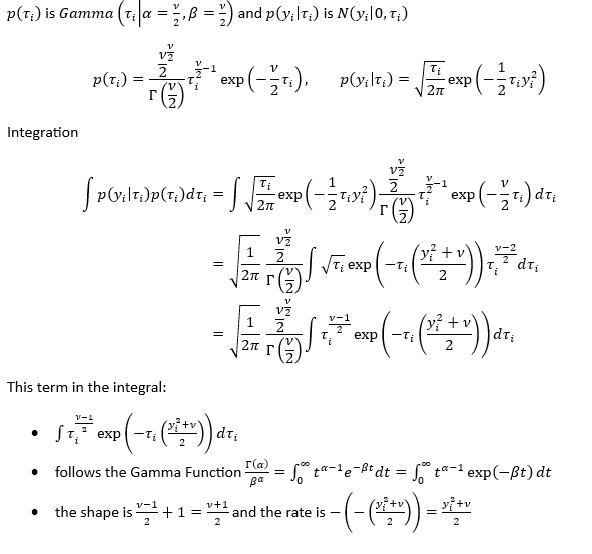

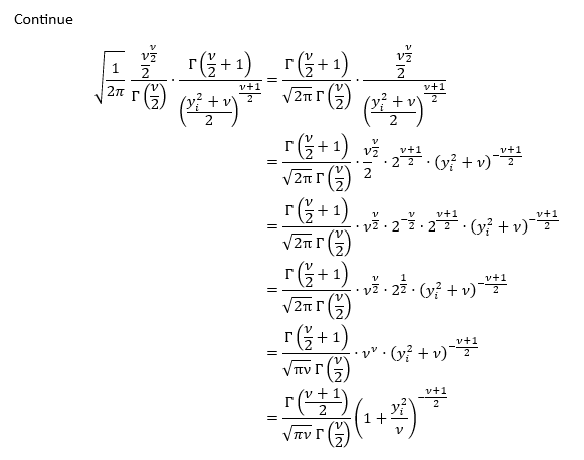

##### explain why the behavior demonstrated here is analagous to that of the posterior predictive distribution.

...

After integrating out the uncertainty in tau_i, we see that for y_i it is the **student t distribution** .


* It is analogous to the posterior predictive distribution because both involve integrating out uncertainty in parameters to make predictions about the data. 
* for the posterior predictive distribution, we compute the predictions by averaging over/integrating plausible values according to uncertainty
* in our example, we had Gamma for prior and we integrated over tau which let to the student t distribution. 
* student t distribution has heavy tails which is better for uncertainty
